<img src="https://cdn.bulbagarden.net/upload/2/21/001Bulbasaur.png" alt="Bulbasaur Pic" style="width: 256px;"/>

# Generate Card Images

1. Download Ken Sugimori art from [bulbapedia](https://archives.bulbagarden.net/wiki/Category:Ken_Sugimori_Pok%C3%A9mon_artwork), augment
2. Use [DRAGAN](https://github.com/kodalinaveen3/DRAGAN) to generate new pokemon art
3. Use PIL to combine random char-rnn generated card properties and DRAGAN generated art, using [templates](https://pokemoncardresources.deviantart.com/gallery/51274687/Resources-Classic)

## Download from Bulbapedia

## Download from pkparaiso

In [ ]:
import glob, shutil, json, requests, collections
data_dir = '/home/ubuntu/fastai-data/pokemon_img'

for gif in glob.glob(os.path.join(data_dir, 'gifs', '*.gif')):
    name = gif.split('/')[-1][:-4].split('-')[0]
    response = requests.get('https://api.pokemontcg.io/v1/cards?name={}&supertype=pokemon'.format(name))
    try:
        types = json.loads(response.content.decode('utf-8'))['cards'][-1]['types'][0]
        for png in glob.glob(os.path.join(data_dir, 'pngs', '{}*.png'.format(name))):
            os.makedirs(os.path.join(data_dir, 'train', types), exist_ok=True)
            shutil.move(png, os.path.join(data_dir, 'train', types))
            if types == 'Lightning':
                print(gif)
    except:
        print(name)

## Create GAN

- Basically copied [makegirlsmoe](https://makegirlsmoe.github.io/assets/pdf/technical_report.pdf)'s architecture and [pytorch DRAGAN](https://github.com/jfsantos/dragan-pytorch/blob/master/dragan.py) / [keras WGAN-GP](https://github.com/farizrahman4u/keras-contrib/blob/master/examples/improved_wgan.py)'s code, because I don't know what I'm doing that well.
- GANs (Generative Adverserial Networks) use a competition between a generator and discriminator neural network to gradually make the generator output match existing samples
    - GANs are inefficient in pure keras - probably good to learn pytorch sometime
    - also don't combine learning a new generator architecture (resnet), a new concept (GANs), and an experimental GAN architecture (DRAGAN) at the same time next time. Especially do not do this all while using the entire data set for training rather than samples.
    - Every batch, first train the discriminator network to correctly classify real and generated images
        - discriminator is a convolutional image classifier network that classifies images as real or fake (binary).
        - discriminator network is actually stacked generator and discriminator, but only discriminator weights are being trained. Input a batch of real images and a batch of noise, feed the noise through the generator and then through the discriminator (real images go straight to discriminator), and optimize discriminator to classify real images as real and generated images as fake.
    - then, train the generator network to fool the discriminator network
        - generator takes noise vector and generates image. In this case we reshape a noise vector into an image, use a dense layer to increase a low resolution image's depth (# of channels), convolutional layers to create features, and pixel shuffles to increase resolution by decreasing depth, until we end up with an appropriate image.
        - generator network is also stacked generator and discriminator, but only the generator weights are trained now. Input a batch of noise, feed it through the generator and discriminator, and optimize the generator so the discriminator classifies the generated images as real (by feeding it the opposite labels).
    - Overall discriminator loss should be lower than generator loss (so generator always has a somewhat accurate goal);  about 0.1-1 discriminator loss and 2-7 generator loss may be good. Loss should not converge but reach equilibrium, as increasing discriminator accuracy leads to better generator which lowers discriminator accuracy and vice versa.
    - DRAGAN adds a gradient penalty to the discriminator to make it easier to train. Creates perturbed images (adding noise vectors to real images) and adds a penalty to the loss function proportional to the gradient of the discriminator at those perturbed images (should make discriminator more linear?)
    - GAN tricks is very helpful, and follow pytorch DRAGAN implementation as closely as possible
        - Remember example implementations and overview papers often don't show things like dropout
- Resnets use skip connections to make networks more linear and help with deep networks
    - resblocks have skip connections, where output from earlier layer is elementwise summed with output from later layer. See resnet paper. This helps make deep networks more linear and generalizable
    - pixel shuffle is used to increase resolution, by making an image tensor wider (higher res) but shallower (fewer channels). See [subpixel](https://github.com/tetrachrome/subpixel)

In [1]:
# imports
from itertools import product

from keras import backend as K
from keras.models import Model
from keras.initializers import *
from keras.layers import *
from keras.engine.topology import Layer
from keras.optimizers import Adam
import itertools, os
import numpy as np

Using TensorFlow backend.


- Defines some layer functions for use in generator and discriminator networks
- pixel shuffle from https://github.com/titu1994/Super-Resolution-using-Generative-Adversarial-Networks/blob/master/models.py
- Appears that changing to upscale + convolution instead of deconvolution (convolution + pixel shuffle) improves diversity of results as well as eliminates checkerboard artifacts?

In [3]:
# residual block for generative network
def g_resblock(x):
    skip = x
    
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Add()([x, skip])
    
    return x

# residual block for discriminator network
def d_resblock(x, filters=32, strides=1):
    skip = x
    
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, 3, padding='same', strides=strides)(x)
    x = Add()([x, skip])
    
    return x

# superresolution CNN
def sp_cnn(x):
    #x = Conv2D(256, 3, padding='same')(x)
    #x = PixelShuffle(2, 64)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    
    return x

- Creates a super-resolution resnet like generator model, and a resnet discriminator model, approx. according to the [technical report](https://makegirlsmoe.github.io/assets/pdf/technical_report.pdf)
- generator model has less resblocks to reduce complexity and make it not converge as fast
- looks more random if activations are removed from sp_cnn blocks?
- Using tanh instead of relu and family seems to make things better as well?
- Adding gaussian noise to input of discriminator might stabilize training

In [35]:
# generator network architecture
def get_generator(x, y, dim=16, depth=64):
    y = Dense(128)(y)
    x = Multiply()([x, y]) # concat noise and class
    x = Dense(dim*dim*depth)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Reshape((dim, dim, depth))(x)
    x = Dropout(0.5)(x)
    skip = x = Conv2D(64, 1, padding='same')(x)

    for i in range(12):
        x = g_resblock(x)
        
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Activation('relu')(x)
    x = Add()([x, skip])
    
    for i in range(3):
        x = sp_cnn(x)
    
    x = Conv2D(3, 9, padding='same')(x)
    x = Activation('tanh')(x)
    
    return x

# discriminator network architecture
def get_discriminator(x):
    x = Conv2D(32, 4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.3)(x)
    
    for i in range(5):
        x = d_resblock(x, filters=2**(5+i))
        x = d_resblock(x, filters=2**(5+i))
        if (i < 2):
            x = Conv2D(2**(6+i), 4, strides=2, padding='same')(x)
        else:
            x = Dropout(0.1)(x)
            x = Conv2D(2**(6+i), 3, strides=2, padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    y = Dense(11)(x) # classify type of pokemon
    y = Activation('softmax')(y)
    x = Dense(1)(x) # classify real or fake
    x = Activation('sigmoid')(x)
    
    return (x, y)

In [36]:
g_input = Input(shape=[128], name='noise')
g_input2 = Input(shape=[11], name='type')
generator = Model(inputs=[g_input, g_input2], outputs=get_generator(g_input, g_input2))

g_test = generator.predict({'noise': np.random.normal(size=(8, 128), scale=1),
                            'type': np.eye(11)[np.random.choice(11, 8)]})
print('max: {} min: {} mean: {}'.format(np.max(g_test), np.min(g_test), np.mean(g_test)))

max: 0.10028956085443497 min: -0.0794169157743454 mean: 0.002273330930620432


In [37]:
d_input = Input(shape=[128, 128, 3], name='images')
discriminator = Model(inputs=d_input, outputs=get_discriminator(d_input))

d_test, d_test2 = discriminator.predict({'images': g_test})
print('max: {} min: {} mean: {}'.format(np.max(d_test), np.min(d_test), np.mean(d_test)))

max: 0.4994427263736725 min: 0.498884379863739 mean: 0.4992273151874542


- Converts generator and discriminator networks into the form required for DRAGAN training
    - adds nontrainable discriminator network layers to generator, to allow us to maximize discriminator loss
    - adds other loss functions and inputs to discriminator network, so it trains on real examples as well as generated examples, and uses the DRAGAN gradient penalty
    - generator should have lower learning rate than discriminator

In [80]:
batch_size = 128



# discriminator_model trains discriminator with real and generated images
for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False

# blog article suggests perturbing in all directions (-1 to 1 rather than 0 to 1)
def perturb(input, c=0.5):
    b, row, col, k = batch_size, 128, 128, 3 #input.shape
    alpha = K.repeat_elements(K.repeat_elements(K.repeat_elements(
        K.random_uniform((b, 1, 1, 1), 0, 1), row, 1), col, 2), k, 3)
    x_hat = alpha*input + (1-alpha)*(input + c * K.std(input) * K.random_uniform((b, row, col, k), -1, 1))
    return x_hat

# inputs for stacked generator/discriminator
imgs = Input(shape=[128, 128, 3]) # real mini-batch
p_imgs = Lambda(perturb, output_shape=K.int_shape(imgs)[1:])(imgs) # perturbed mini-batch
noise = Input(shape=[128])
types = Input(shape=[11])

# from keras WGAN-GP, though called with randomly perturbed inputs rather than averaged inputs
def gradient_penalty(y_true, y_pred, x_hat=p_imgs):
    gradients = K.gradients(K.sum(y_pred), x_hat)
    gradient_l2_norm = K.sqrt(K.sum(K.square(gradients), axis=[1,2,3]))
    gradient_penalty = K.mean(K.square(gradient_l2_norm - 1))
    return gradient_penalty

# discriminator model with inputs both real and generated images
discriminator_model = Model(inputs=[imgs, noise, types],
                    outputs=discriminator(imgs)+discriminator(generator([noise, types]))+discriminator(p_imgs))
discriminator_model.compile(optimizer=Adam(5e-4),
                    loss=['binary_crossentropy', 'categorical_crossentropy',
                          'binary_crossentropy', 'categorical_crossentropy',
                          gradient_penalty, gradient_penalty],
                    loss_weights=[1.8, 0.2, 0.9, 0.1, 0.0, 0])

#test2 = discriminator_model.predict([generator.predict(np.random.normal(size=(4, 128))),
#                                     np.random.normal(size=(4, 128))])
#print('max: {} min: {} mean: {}'.format(np.max(test2[1]), np.min(test2[1]), np.mean(test2[1])))
discriminator_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (None, 11)           0                                            
__________________________________________________________________________________________________
model_14 (Model)                (None, 128, 128, 3)  3241475     input_26[0][0]                   
                                                                 input_27[0][0]                   
__________

In [81]:
# generator_model trains generator to create image, optimizes to maximize discriminator loss
for layer in discriminator.layers:
    layer.trainable = False
for layer in generator.layers:
    layer.trainable = True
discriminator.trainable = False
generator.trainable = True

generator_model = Model(inputs=[noise, types], outputs=discriminator(generator([noise, types])))
generator_model.compile(optimizer=Adam(2e-3),
                        loss=['binary_crossentropy', 'categorical_crossentropy'],
                        loss_weights=[0.9, 0.1])

#test = generator_model.predict(np.random.normal(size=(4, 256)))
#print('max: {} min: {} mean: {}'.format(np.max(test), np.min(test), np.mean(test)))
generator_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (None, 11)           0                                            
__________________________________________________________________________________________________
model_14 (Model)                (None, 128, 128, 3)  3241475     input_26[0][0]                   
                                                                 input_27[0][0]                   
__________________________________________________________________________________________________
model_15 (Model)                [(None, 1), (None, 1 18984300    model_14[10][0]                  
Total para

## Training Your DRAGAN

In [59]:
from keras.preprocessing import image
from matplotlib import pyplot as plt
import numpy as np
import random, os

# Instantiate plotting tool
%matplotlib inline

In [60]:
def plots(ims, figsize=(12,6), rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [61]:
data_dir = '/home/ubuntu/fastai-data/pokemon_img'
train_path = os.path.join(data_dir, 'train')
temp_path = os.path.join(data_dir, 'temp')
result_path = os.path.join(data_dir, 'results')

Found 38376 images belonging to 11 classes.
max: 0.99609375 min: -0.99609375 mean: 0.7859818339347839


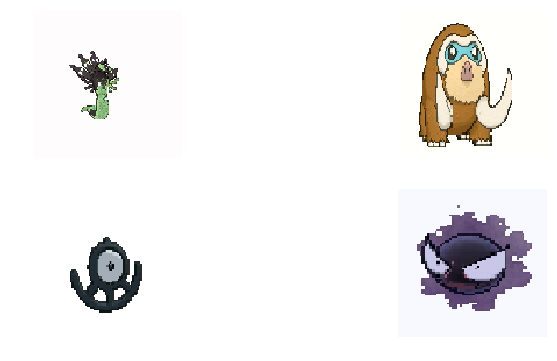

In [62]:
def get_batches(dirname, temp_dir=None, shuffle=True, batch_size=batch_size):
    gen = image.ImageDataGenerator(preprocessing_function=lambda x: (x - 127.5)/128,
                                  horizontal_flip=True,
                                  width_shift_range=0.09,
                                  height_shift_range=0.09,
                                  zoom_range=[1.1, 1.65],
                                  shear_range=0.05,
                                  fill_mode='constant',
                                  cval=255,
                                  channel_shift_range=8)
    return gen.flow_from_directory(dirname,
                                  target_size=(128,128),
                                  class_mode='categorical',
                                  color_mode='rgb',
                                  shuffle=shuffle,
                                  save_to_dir=temp_dir,
                                  batch_size=batch_size)

#batches = get_batches(train_path, temp_dir=temp_path)
batches = get_batches(train_path)

for i in range(5):
    batch, labels = next(batches)
print('max: {} min: {} mean: {}'.format(np.max(batch), np.min(batch), np.mean(batch)))
plots([image.load_img(os.path.join(temp_path, img)) for img in random.sample(os.listdir(temp_path), 4)])

In [63]:
from PIL import Image

def tile_images(image_stack):
    assert len(image_stack.shape) == 4
    image_list = [image_stack[i, :, :, :] for i in range(image_stack.shape[0])]
    #image_list = [image_stack[i, :, :] for i in range(image_stack.shape[0])]
    tiled_images = np.concatenate(image_list, axis=1)
    #tiled_images = np.swapaxes(tiled_images, 0, 2)
    return tiled_images

def generate_images(generator, output_dir, epoch):
    test_image_stack = generator.predict([np.random.normal(size=(8, 128), scale=1), np.eye(11)[:8]]) 
    test_image_stack = (test_image_stack * 127.5) + 127.5
    test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
    tiled_output = tile_images(test_image_stack)
    tiled_output = Image.fromarray(tiled_output, mode='RGB')
    outfile = os.path.join(output_dir, 'epoch_{}.png'.format(epoch))
    tiled_output.save(outfile)

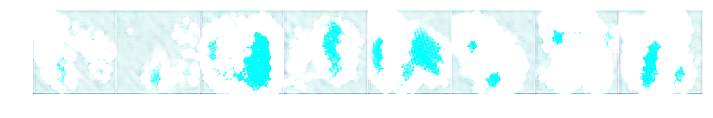

In [64]:
#import dcgan
#generator = dcgan.generator_model()
#generator.compile(optimizer=Adam(0.0001), loss='binary_crossentropy')

test_image_stack = generator.predict([np.random.normal(size=(8, 128), scale=1), np.eye(11)[np.random.choice(11, 8)]])
test_image_stack = (test_image_stack * 127.5) + 127.5
test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
tiled_output = tile_images(test_image_stack)
tiled_output = Image.fromarray(tiled_output, mode='RGB')
outfile = os.path.join(temp_path, 'perturb_test.png')
tiled_output.save(outfile)

plots([image.load_img(outfile)])

- Concensus from [Animeface-GAN](https://github.com/forcecore/Keras-GAN-Animeface-Character) and others seems to be generator loss of 2-4 and discriminator loss around 0.3 is good
- One sided label noising and both sided label smoothing for discriminator, no smoothing or noising for generator seems to work well for me

In [ ]:
sample_period = int(38376 / batch_size / 5)
true_positive_y = np.ones((batch_size, 1))
true_negative_y = np.zeros((batch_size, 1))
dummy_y = np.zeros((batch_size, 1)) + 0.5

epoch = 91
if epoch > 0:
    generator_model.load_weights(os.path.join(result_path, 'gan_g_weights{}.h5'.format(epoch)))
    discriminator_model.load_weights(os.path.join(result_path, 'gan_d_weights{}.h5'.format(epoch)))
    """
    discriminator_loss = np.loadtxt(os.path.join(result_path, 'gan_d_loss_history.csv'))
    discriminator_loss = list(np.broadcast_to(
        np.expand_dims(discriminator_loss, axis=1),(discriminator_loss.shape[0], 4)))
    generator_loss =  list(np.loadtxt(os.path.join(result_path, 'gan_g_loss_history.csv')))
    batch_num = len(discriminator_loss) + 1
    """
    discriminator_loss = []
    generator_loss = []
    batch_num = 0
else:
    discriminator_loss = []
    generator_loss = []
    batch_num = 0

epoch += 1
print('Epoch ' + str(epoch) + '\n')
for imgs, types in batches:
    
    # save weights and generate sample images every so often
    if batch_num % sample_period == 0 and batch_num > 1:
        generate_images(generator, result_path, epoch)
        if generator_loss[-1][0] > 0.5:
            try:
                generator_model.save_weights(os.path.join(result_path, 'gan_g_weights{}.h5'.format(epoch)))
                discriminator_model.save_weights(os.path.join(result_path, 'gan_d_weights{}.h5'.format(epoch)))
            except:
                print('Weights could not be saved')
        epoch += 1
        print('\nEpoch ' + str(epoch))
    
    if len(imgs) == batch_size:
        # smooth positive labels only
        positive_y = np.random.uniform(0.85, 1.1, size=(batch_size, 1))
        negative_y = np.zeros((batch_size, 1))+0.05
    
        # train discriminator with real, generated, and perturbed images
        noise = np.random.normal(size=(batch_size, 128), scale=1)
        gen_types = np.eye(11)[np.random.choice(11, batch_size)]
        discriminator_loss.append(
            discriminator_model.train_on_batch([imgs, noise, gen_types],
                                               [positive_y, types, negative_y, gen_types, dummy_y, gen_types]))

        # train generator to maximize discriminator loss
        noise2 = np.random.normal(size=(batch_size, 128), scale=1)
        gen_types2 = np.eye(11)[np.random.choice(11, batch_size)]
        generator_loss.append(
            generator_model.train_on_batch([noise2, gen_types2], [positive_y, gen_types2]))
        
        print('D. Loss | Total: ' + str(discriminator_loss[-1][0])
              + ' | Real: ' + str(discriminator_loss[-1][1])
              + ' | Fake: ' + str(discriminator_loss[-1][3])
              + ' | Penalty: ' + str(discriminator_loss[-1][5])
              + ' | Categorical: '+str(discriminator_loss[-1][2]))
        np.savetxt(os.path.join(result_path, 'gan_d_loss_history.csv'), np.asarray(discriminator_loss)[:,0])
        
        print('G. Loss | Total: ' + str(generator_loss[-1][0])
             + ' | Real/Fake: ' +  str(generator_loss[-1][1])
             + ' | Categorical: ' + str(generator_loss[-1][2]))
        np.savetxt(os.path.join(result_path, 'gan_g_loss_history.csv'), np.asarray(generator_loss)[:,0])
        
    batch_num += 1

Epoch 92



/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D. Loss | Total: 0.786971 | Real: 0.13234 | Fake: 0.198626 | Penalty: 0.816698 | Categorical: 0.64677
G. Loss | Total: 2.85381 | Real/Fake: 2.9051 | Categorical: 2.39214
D. Loss | Total: 0.761142 | Real: 0.110366 | Fake: 0.198632 | Penalty: 0.802386 | Categorical: 0.708813
G. Loss | Total: 2.8542 | Real/Fake: 2.90397 | Categorical: 2.40626
D. Loss | Total: 0.78413 | Real: 0.104461 | Fake: 0.198634 | Penalty: 0.835745 | Categorical: 0.885388
G. Loss | Total: 2.84019 | Real/Fake: 2.88547 | Categorical: 2.43266
D. Loss | Total: 0.732274 | Real: 0.0968623 | Fake: 0.19867 | Penalty: 0.845984 | Categorical: 0.708212
G. Loss | Total: 2.85372 | Real/Fake: 2.90075 | Categorical: 2.43045
D. Loss | Total: 0.83541 | Real: 0.14915 | Fake: 0.19867 | Penalty: 0.862479 | Categorical: 0.736607
G. Loss | Total: 2.81843 | Real/Fake: 2.86538 | Categorical: 2.39586
D. Loss | Total: 0.781894 | Real: 0.112415 | Fake: 0.198657 | Penalty: 0.87926 | Categorical: 0.799811
G. Loss | Total: 2.85908 | Real/Fake: 2.

D. Loss | Total: 0.72223 | Real: 0.103275 | Fake: 0.198589 | Penalty: 0.902801 | Categorical: 0.576326
G. Loss | Total: 2.88968 | Real/Fake: 2.94355 | Categorical: 2.40482
D. Loss | Total: 0.784659 | Real: 0.141403 | Fake: 0.198582 | Penalty: 0.894586 | Categorical: 0.551037
G. Loss | Total: 2.84516 | Real/Fake: 2.89308 | Categorical: 2.41386
D. Loss | Total: 0.773133 | Real: 0.137775 | Fake: 0.198579 | Penalty: 0.871769 | Categorical: 0.52423
G. Loss | Total: 2.82193 | Real/Fake: 2.86865 | Categorical: 2.40141
D. Loss | Total: 0.81028 | Real: 0.141331 | Fake: 0.198629 | Penalty: 0.888961 | Categorical: 0.697553
G. Loss | Total: 2.80304 | Real/Fake: 2.84665 | Categorical: 2.41056
D. Loss | Total: 0.800866 | Real: 0.137293 | Fake: 0.198674 | Penalty: 0.830113 | Categorical: 0.678919
G. Loss | Total: 2.7889 | Real/Fake: 2.83115 | Categorical: 2.40866
D. Loss | Total: 0.815373 | Real: 0.138503 | Fake: 0.198742 | Penalty: 0.831507 | Categorical: 0.731481
G. Loss | Total: 2.76894 | Real/Fak

D. Loss | Total: 0.739235 | Real: 0.13581 | Fake: 0.198691 | Penalty: 0.861229 | Categorical: 0.370923
G. Loss | Total: 2.86977 | Real/Fake: 2.91882 | Categorical: 2.42834
D. Loss | Total: 0.697216 | Real: 0.0931508 | Fake: 0.198598 | Penalty: 0.842933 | Categorical: 0.559331
G. Loss | Total: 2.96544 | Real/Fake: 3.02719 | Categorical: 2.40976
D. Loss | Total: 0.743363 | Real: 0.111157 | Fake: 0.198794 | Penalty: 0.837321 | Categorical: 0.616237
G. Loss | Total: 2.99998 | Real/Fake: 3.06571 | Categorical: 2.40845
D. Loss | Total: 0.759402 | Real: 0.137438 | Fake: 0.199039 | Penalty: 0.823213 | Categorical: 0.455638
G. Loss | Total: 2.99211 | Real/Fake: 3.05695 | Categorical: 2.40852
D. Loss | Total: 0.801142 | Real: 0.150495 | Fake: 0.199102 | Penalty: 0.807388 | Categorical: 0.551251
G. Loss | Total: 2.88132 | Real/Fake: 2.93636 | Categorical: 2.386
D. Loss | Total: 0.767412 | Real: 0.14963 | Fake: 0.198594 | Penalty: 0.829387 | Categorical: 0.397632
G. Loss | Total: 2.76349 | Real/Fa

D. Loss | Total: 0.715897 | Real: 0.130687 | Fake: 0.198681 | Penalty: 0.824046 | Categorical: 0.313078
G. Loss | Total: 2.82161 | Real/Fake: 2.86899 | Categorical: 2.39525
D. Loss | Total: 0.625999 | Real: 0.0710019 | Fake: 0.198694 | Penalty: 0.841433 | Categorical: 0.395561
G. Loss | Total: 2.8805 | Real/Fake: 2.93413 | Categorical: 2.39785
D. Loss | Total: 0.754169 | Real: 0.138332 | Fake: 0.198622 | Penalty: 0.850665 | Categorical: 0.424913
G. Loss | Total: 2.85907 | Real/Fake: 2.9092 | Categorical: 2.40784
D. Loss | Total: 0.721782 | Real: 0.12724 | Fake: 0.198599 | Penalty: 0.843321 | Categorical: 0.36357
G. Loss | Total: 2.88735 | Real/Fake: 2.94123 | Categorical: 2.40241
D. Loss | Total: 0.788766 | Real: 0.13495 | Fake: 0.198599 | Penalty: 0.860033 | Categorical: 0.627881
G. Loss | Total: 2.88922 | Real/Fake: 2.94053 | Categorical: 2.42746
D. Loss | Total: 0.732454 | Real: 0.135349 | Fake: 0.19862 | Penalty: 0.85863 | Categorical: 0.344936
G. Loss | Total: 2.86343 | Real/Fake:

D. Loss | Total: 0.950535 | Real: 0.108353 | Fake: 0.212886 | Penalty: 0.737046 | Categorical: 1.61443
G. Loss | Total: 1.863 | Real/Fake: 1.79965 | Categorical: 2.43318
D. Loss | Total: 1.0769 | Real: 0.117892 | Fake: 0.256069 | Penalty: 0.782316 | Categorical: 1.96301
G. Loss | Total: 1.98499 | Real/Fake: 1.93455 | Categorical: 2.43892
D. Loss | Total: 1.00844 | Real: 0.11877 | Fake: 0.246968 | Penalty: 0.750875 | Categorical: 1.65478
G. Loss | Total: 2.38889 | Real/Fake: 2.38772 | Categorical: 2.39948
D. Loss | Total: 1.44628 | Real: 0.137812 | Fake: 0.67023 | Penalty: 0.840582 | Categorical: 1.59009
G. Loss | Total: 3.11506 | Real/Fake: 3.18887 | Categorical: 2.45072
D. Loss | Total: 1.22144 | Real: 0.112713 | Fake: 0.453079 | Penalty: 0.816972 | Categorical: 1.73866
G. Loss | Total: 4.86395 | Real/Fake: 5.12398 | Categorical: 2.52367
D. Loss | Total: 1.25556 | Real: 0.278565 | Fake: 0.245477 | Penalty: 0.0860702 | Categorical: 1.38696
G. Loss | Total: 3.72562 | Real/Fake: 3.85746 

D. Loss | Total: 0.874059 | Real: 0.126502 | Fake: 0.198738 | Penalty: 0.823203 | Categorical: 1.12583
G. Loss | Total: 2.83489 | Real/Fake: 2.88281 | Categorical: 2.40366
D. Loss | Total: 0.904008 | Real: 0.158876 | Fake: 0.198771 | Penalty: 0.872477 | Categorical: 1.00209
G. Loss | Total: 2.74964 | Real/Fake: 2.7885 | Categorical: 2.39989
D. Loss | Total: 0.79073 | Real: 0.126594 | Fake: 0.198996 | Penalty: 0.862503 | Categorical: 0.727132
G. Loss | Total: 2.77284 | Real/Fake: 2.81157 | Categorical: 2.42434
D. Loss | Total: 0.804736 | Real: 0.100861 | Fake: 0.198952 | Penalty: 0.845809 | Categorical: 1.0044
G. Loss | Total: 2.8348 | Real/Fake: 2.88087 | Categorical: 2.42021
D. Loss | Total: 0.92106 | Real: 0.183783 | Fake: 0.198736 | Penalty: 0.798453 | Categorical: 0.861394
G. Loss | Total: 2.8253 | Real/Fake: 2.8712 | Categorical: 2.41213
D. Loss | Total: 0.727938 | Real: 0.0791928 | Fake: 0.198689 | Penalty: 0.808933 | Categorical: 0.83442
G. Loss | Total: 2.93899 | Real/Fake: 2.9

D. Loss | Total: 0.769446 | Real: 0.106189 | Fake: 0.198637 | Penalty: 0.796715 | Categorical: 0.789276
G. Loss | Total: 2.86176 | Real/Fake: 2.91047 | Categorical: 2.42339
D. Loss | Total: 0.851653 | Real: 0.163183 | Fake: 0.198698 | Penalty: 0.818357 | Categorical: 0.696545
G. Loss | Total: 2.79931 | Real/Fake: 2.84302 | Categorical: 2.40596
D. Loss | Total: 0.731503 | Real: 0.091732 | Fake: 0.198672 | Penalty: 0.762095 | Categorical: 0.741435
G. Loss | Total: 2.84421 | Real/Fake: 2.89282 | Categorical: 2.40669
D. Loss | Total: 0.789577 | Real: 0.147133 | Fake: 0.19868 | Penalty: 0.79309 | Categorical: 0.523974
G. Loss | Total: 2.84087 | Real/Fake: 2.88798 | Categorical: 2.41685
D. Loss | Total: 0.772443 | Real: 0.115975 | Fake: 0.19868 | Penalty: 0.801956 | Categorical: 0.708337
G. Loss | Total: 2.90695 | Real/Fake: 2.963 | Categorical: 2.40252
D. Loss | Total: 0.693515 | Real: 0.0649327 | Fake: 0.198695 | Penalty: 0.640897 | Categorical: 0.786286
G. Loss | Total: 3.00018 | Real/Fak

D. Loss | Total: 0.711803 | Real: 0.115419 | Fake: 0.198617 | Penalty: 0.832849 | Categorical: 0.426478
G. Loss | Total: 2.86715 | Real/Fake: 2.91942 | Categorical: 2.39665
D. Loss | Total: 0.787931 | Real: 0.129555 | Fake: 0.198629 | Penalty: 0.859882 | Categorical: 0.666644
G. Loss | Total: 2.86544 | Real/Fake: 2.91718 | Categorical: 2.39974
D. Loss | Total: 0.828274 | Real: 0.146256 | Fake: 0.198594 | Penalty: 0.852484 | Categorical: 0.722964
G. Loss | Total: 2.84628 | Real/Fake: 2.8951 | Categorical: 2.4069
D. Loss | Total: 0.711899 | Real: 0.107573 | Fake: 0.198615 | Penalty: 0.864181 | Categorical: 0.494618
G. Loss | Total: 2.89979 | Real/Fake: 2.95454 | Categorical: 2.40703
D. Loss | Total: 0.855108 | Real: 0.171043 | Fake: 0.198602 | Penalty: 0.867367 | Categorical: 0.639434
G. Loss | Total: 2.83859 | Real/Fake: 2.8878 | Categorical: 2.39569
D. Loss | Total: 0.705956 | Real: 0.101586 | Fake: 0.19861 | Penalty: 0.858745 | Categorical: 0.51824
G. Loss | Total: 2.87616 | Real/Fake

## Compare with hypergan card images because keras is soooo slow

- Seriously, raw tensorflow is like at least 10 times faster than keras for this. Also keras keeps making me tweak the hyperparameters every few epochs to avoid nans. I really should learn pytorch soon. Maybe my generator and discriminator architectures are overkill, but the double evaluation for each model and the gradient penalty are very inefficient in keras.

- Looks like hypergan isn't very effective for this task either - discriminator or generator loss goes to 0 after just a few epochs, no matter what hyperparameters I try. May need more data augmentation, and it's easier to do that in keras.